# Tutorial: Protein Folding with Quantum Approximate Optimization Algorithm (QAOA)

by: Hanna Linn, WACQT Chalmers

This tutorial walks through performing protein folding of the hydrophobic-polar lattice model in two dimensions using Quantum Approximate Optimization Algorithm (QAOA). 

## Overview
In this tutorial, we start by defining our amino acid sequence of what we want to fold together with a lattice grid on which we want to fold our sequence. We then define an energy function that, given a folding (placement) of the sequence on the grid, gives us a potential. The goal is to find the folding with the lowest potential, called the native state of the amino acid sequence. We usually have more than one native state, all with the same energy. The process can be defined as an optimisation:

Given an energy function, $E(x)$, and a folding $x$:
\begin{equation}
\begin{array}{ll@{}ll}
\text{minimise}  & E(x) &\\
\text{subject to}& x \in F, & &
\end{array}
\end{equation}
where $F$ is the feasible solution set of the problem, i.e., all $ x \in F$ translates to physically possible protein folding.

For details of the energy function used in this tutorial, please see Irbäck et al. 2022: 
https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043013

Here, we aim to do the optimisation with the Quantum Approximate Optimization Algorithm (QAOA) using Pennylane https://pennylane.ai/qml/demos/tutorial_qaoa_intro

In [26]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from matplotlib.ticker import MultipleLocator, NullFormatter, MaxNLocator
import math
from itertools import product
import matplotlib
from matplotlib import cm
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Protein model

The HP-lattice model in two dimensions has two types of beads: H for hydrophobic and P for polar. We can make an instance of the model by defining the sequence with 1 for H and 0 for P and a lattice grid size.

The model is described in detail in Sec II. "Methods" part B "Binary quadratic model for HP lattice proteins – QUBO encoding" in Irbäck et al. 2022.
https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043013

The energy function can be defined as:
\begin{equation}
    E = E_{HP} + \sum_{i=1}^3 \lambda_i E_i,
\end{equation}
where $E_{HP}$ is the energy term for the HP model and the terms $E_1$, $E_2$ and $E_3$ are constraint energies with the penalty vector $\lambda_i,\ i=1,2,3$ controlling the strength of the constraints.

\begin{equation}
    E_{HP} = - \sum_{|f-f'|>1}C(h_f, h_f') \sum_{(s,s')}\sigma_s^f\sigma_{s'}^{f'}
\end{equation}

\begin{equation}
    C(h_f,h_{f'}) =     \begin{cases}
      1, & \text{if } h_f = h_{f'} = \text{H}, \\
      0, & \text{otherwise}.
    \end{cases} 
\end{equation}

\begin{equation}
    E_1 = \sum_f \left(\sum_s\sigma_s^f-1\right)^2 + \left\{ \text{same for odd parity} \right\}
\end{equation}

\begin{equation}
    E_2 = \frac{1}{2} \sum_{f_1 \not = f_2} \sum_s \sigma_s^f\sum_{||s'-s||>1} \sigma_{s'}^{f+1} + \left\{ \text{same for odd parity} \right\}
\end{equation}

\begin{equation}
\begin{split}
    E_3 =& \sum_{1 \leq f<N} \sum_s \sigma_s^f \sum_{||s'-s||>1} \sigma_{s'}^{f+1} \\
    & + \left\{ \text{same with odd/even parity interchanged} \right\},
\end{split}
\end{equation}
where $\sigma_s^f$ to describe the location of the even beads. The index $f$ is the beads and $s$ is the sites (' are the odd beads and sites). The $\sigma_s^f=1$ if bead $f$ is located on site $s$, and $\sigma_s^f=0$ otherwise, same for odds. The sites and beads are divided into odds and even to reduce the number of bits required from the number of amino acids times the area of the grid to half.

The terms in the energy function can be clumped together to one-body energy $O_i$, and two-body interaction $T_{ij}$, the pairwise interaction potentials.
The energy function to optimize can be written as
\begin{equation}
    E(x) = \underbrace{\sum^N_{i=1} O_i x_i}_\text{one-body} + \underbrace{\sum^{N-1}_{i=1}\sum^N_{j=i+1} T_{ij}x_ix_j}_\text{two-body},
\end{equation}
where $x_i$ is a bitstring representing the folding on the lattice. $x_1$ is the choise, 1 for yes and 0 for no, of putting the first amino acid on position (0,0) on the grid.

In [2]:
'''
This cell is backend code. Don't mind it. Just run the cell.

HP-lattice Coordninate-based HP-lattice model
Written by Hanna Linn, hannlinn@chalmers.se
Based on Lucas Knuthsons code.
If used, please cite Irbäck et al. 2022: 
https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043013
'''


class CoordinateBased_HPLattice:
	'''
	Class for one instance of the 2D lattice HP-model to then be fed into the quantum simulation.

	Class variables in order of creation [type]:
	After init:
		- dim_lattice = dimensions of the lattice (rows, columns) [tuple of two ints]
		- lambda_vector = penalty terms for the energy terms [tuple of three ints]
		- sequence = Given sequence of the problem. Sequence format: H is 1 and 0 is P, e.g., [H, P, P, H] = [1, 0, 0, 1]. [list of int/binaries]
		- Q = dict with energy info [dictionary]
		- bit_name_list = names of the qubits saved in a list. Name format: (node [tuple], seq [int]) [list of tuples]
		- num_bits = number of bits in the instance [int]
		- O_energies = one-body energies [list of floats]
		- T_energies = two-body energies [list of Numpy Arrays with floats]
		- Dn = Dn vector [number of nodes for placements for each amino acid in sequence] [list] DOES NOT WORK FOR RECTANGULAR LATTICES!!!

	After function call:
		- feasible_set = Numpy arrays of all feasible bitstrings solutions in one-hot encoding [list of Numpy Arrays]
		- solution_set = Numpy arrays of all bitstring solutions in one-hot encoding [list of Numpy Arrays]

	'''

	def __init__(self, dim_lattice, sequence, lambda_vector = (1, 1, 1)):

		self.dim_lattice = dim_lattice
		self.lambda_vector = lambda_vector # best lambdas: lambda_1, lambda_2, lambda_3 = 1, 2, 1.5
		self.sequence = sequence
		self.Q = self.make_Q()

		self.bit_name_list = self.get_bit_names()
		self.num_bits = len(self.bit_name_list)
		self.O_energies = self.get_O_energies()
		self.T_energies = self.get_T_energies()
		self.Dn = self.get_Dn()

	def __str__(self):
		return '\nO:\n' + str(self.O_energies) + '\nT:\n' + str(self.T_energies)

	def get_H_indices(self):
		'''
		The following lists are lists of the indices where
		Hs are positioned.
		Used in make_Q.
		Based on code by: Lucas Knuthson
		'''
		H_index_even = [i for i in range(len(self.sequence)) if self.sequence[i] == 1 and i % 2 == 0]
		H_index_odd = [i for i in range(len(self.sequence)) if self.sequence[i] == 1 and i % 2 == 1]
		return H_index_even, H_index_odd

	def combos_of_H(self):
		'''
		Used in make_Q.
		Based on code by: Lucas Knuthson
		'''
		H_index_even, H_index_odd = self.get_H_indices()
		H_combos = []
		for even in H_index_even:
			for odd in H_index_odd:
				H_combos.append((even, odd))
		return H_combos

	def split_evenodd(self):
		'''
		Split the sequence into a lists of odd and even beads.
		Cates = categories.
		Used in make_Q.
		Based on code by: Lucas Knuthson
		'''
		cates_even = [i for i in range(len(self.sequence)) if i%2 == 0]
		cates_odd = [i for i in range(len(self.sequence)) if i%2 == 1]
		return cates_even, cates_odd

	def make_Q(self, verbose = False):
		'''
		Q is the interactions in the ising model.
		Two-body energy: (q_1, q_2) = value
		One-body energy: (q_1, q_1) = value

		bit format: (node, seq. index)
		Node format: (row, col)
		Based on code by: Lucas Knuthson
		'''
		Q = defaultdict(int)

		cates_even, cates_odd = self.split_evenodd()

		G = nx.grid_2d_graph(self.dim_lattice[0], self.dim_lattice[1]) # makes a lattice as a graph

		# EPH
		H_combos = self.combos_of_H()
		count_HP = 0
		#print('HP')
		for u,v in G.edges():
			for x,y in H_combos:
				if (x-y)**2 > 4:
					if sum(u) % 2 != 1 and sum(v) % 2 == 1:
						Q[((u,x), (v,y))] -= 1
						count_HP += 1
						#print('-', ((u,x), (v,y)))
					elif sum(u) % 2 == 1 and sum(v) % 2 != 1:
						Q[((v,x), (u,y))] -= 1
						count_HP += 1
						#print('-', ((v,x), (u,y)))
					
		# Sums over the squared sums, lambda 1
		count_onper = 0
		#print('Sums over the squared sums')
		#even
		for i in cates_even:
			# One body
			for u in G.nodes():
				if sum(u) % 2 != 1:
					Q[((u,i), (u,i))] -= 1*self.lambda_vector[0]
					count_onper += 1
					#print('-', ((u,i), (u,i)))

			# Two body
			for u in G.nodes():
				for v in G.nodes():
					if u != v and (sum(u) % 2 != 1 and sum(v) % 2 != 1) :
						Q[((u,i),(v,i))] += 2*self.lambda_vector[0]
						count_onper += 1
						#print(((u,i),(v,i)))

		#odd
		for i in cates_odd:
			# One body
			for u in G.nodes():
				if sum(u) % 2 == 1:
					Q[((u,i),(u,i))] -= 1*self.lambda_vector[0]
					count_onper += 1
					#print('-', ((u,i),(u,i)))

			# Two body
			for u in G.nodes():
				for v in G.nodes():
					if u != v and (sum(u) % 2 == 1 and sum(v) % 2 == 1):
						Q[((u,i),(v,i))] += 2*self.lambda_vector[0]
						count_onper += 1
						#print(((u,i),(v,i)))

		# self-avoidance, lambda 2
		#print('self-avoidance')
		count_sa = 0
		for u in G.nodes():
			if sum(u) % 2 != 1: # even beads
				for x in cates_even:
					for y in cates_even:
						if x != y and x < y:
							Q[((u,x), (u,y))] += 1*self.lambda_vector[1]
							count_sa += 1
							#print(((u,x), (u,y)))
			elif sum(u) % 2 == 1: # odd beads
				for x in cates_odd:
					for y in cates_odd:
						if x != y and x < y:
							Q[((u,x), (u,y))] += 1*self.lambda_vector[1]
							count_sa += 1
							#print(((u,x), (u,y)))

		# Connectivity sums, lambda 3
		# Even
		#print('Connectivity sums')
		count_con = 0
		for i in cates_even:
			for u in G.nodes():
				for v in G.nodes():
					if (((u,v) in G.edges()) == False and ((v,u) in G.edges()) == False) and u != v:
						if sum(u) % 2 != 1 and sum(v) % 2 == 1 and len(self.sequence) % 2 == 0:
							count_con += 1
							#print(((u,i), (v,i+1)))
							Q[((u,i), (v,i+1))] += 1*self.lambda_vector[2]

						elif sum(u) % 2 != 1 and sum(v) % 2 == 1 and len(self.sequence) % 2 == 1:
							if i != cates_even[-1]:
								Q[((u,i), (v,i+1))] += 1*self.lambda_vector[2]
								count_con += 1
								#print(((u,i), (v,i+1)))
		# Odd
		for i in cates_odd:
			for u in G.nodes():
				for v in G.nodes():
					if (((u,v) in G.edges()) == False and ((v,u) in G.edges()) == False) and u != v:
						if (sum(u) % 2 != 1 and sum(v) % 2 == 1) and len(self.sequence) % 2 == 1:
							Q[((u,i+1), (v,i))] += 1*self.lambda_vector[2]
							count_con += 1
							#print(((u,i+1), (v,i)))

						elif (sum(u) % 2 != 1 and sum(v) % 2 == 1) and len(self.sequence) % 2 == 0:
							if i != cates_odd[-1]:
								count_con += 1
								#print(((u,i+1), (v,i)))
								Q[((u,i+1), (v,i))] += 1*self.lambda_vector[2]

		if verbose:
			print('Counts:')
			print('HP: ', count_HP)
			print('onper, lambda 1: ', count_onper)
			print('self-avoidance, lambda 2: ', count_sa)
			print('connectivity, lambda 3: ', count_con)

		Q = dict(Q) # not a defaultdict anymore to not be able to grow by error
		return Q

	def get_node_list(self, verbose = False):
		'''
		Returns a list of the nodes in the right order: snakey!
		Verbose will print resulting list and saves a .png of the graph.
		'''
		node_list = []
		(Lrow, Lcol) = self.dim_lattice
		G = nx.grid_2d_graph(Lrow, Lcol)

		for row in range(Lrow):
			start_index = row * Lcol
			if row % 2 == 0: # even row is forward
				node_list.extend(list(G.nodes())[start_index:start_index + Lcol])
			if row % 2 == 1: # odd row is backward
				node_list.extend(reversed(list(G.nodes())[start_index:start_index + Lcol]))
		if verbose:
			nx.draw(G, with_labels=True)
			plt.savefig('Lattice')
			print(node_list)
		return node_list

	def get_bit_names(self):
		'''
		Returns a list of all the bitnames in the form (node (row, col), seq) in the right order.
		'''

		seq_index = range(len(self.sequence))
		node_list = self.get_node_list(verbose = False)
		bit_name_list = []
		L_2 = int(self.dim_lattice[0]*self.dim_lattice[1])
		nodes_even = [x for x in range(L_2) if x % 2 == 0]
		nodes_odd = [x for x in range(L_2) if x % 2 != 0]
		# for all even nodes with first index aso
		for f in seq_index:
			if f % 2 == 0:
				for s in nodes_even:
					bit_name_list.append((node_list[s], f))
			if f % 2 == 1:
				for s in nodes_odd:
					bit_name_list.append((node_list[s], f))
		return bit_name_list

	def get_O_energies(self):
		'''
		Get the one-body energies for the Hamiltonian.
		'''
		O_energies = []
		for bit in self.bit_name_list:
			try:
				O_energies.append(self.Q[(bit, bit)])
			except:
				pass
		return O_energies

	def get_T_energies(self):
		'''
		Get the two-body energies for the Hamiltonian.
		'''
		T_energies = np.zeros((self.num_bits, self.num_bits))

		for j in range(self.num_bits):
			for k in range(self.num_bits):
				if j == k:
					T_energies[j,k] = 0
				else:
					try:
						T_energies[j,k] = self.Q[self.bit_name_list[j], self.bit_name_list[k]]
						if j > k:
							T_energies[k,j] = self.Q[self.bit_name_list[j], self.bit_name_list[k]]
					except:
						pass

		T_energies = np.triu(T_energies) # delete lower triangle
		T_energies = T_energies + T_energies.T - np.diag(np.diag(T_energies)) # copy upper triangle to lower triangle
		return T_energies

	def get_Dn(self):
		'''
		Cardinality vector. Used for XY-mixer.
		'''
		D = []
		for seq in range(len(self.sequence)):
			if seq % 2 == 0:
				D.append(math.ceil((self.dim_lattice[0]*self.dim_lattice[1])/2))
			if seq % 2 == 1:
				D.append(math.floor((self.dim_lattice[0]*self.dim_lattice[1])/2))
		return D

	def get_feasible_percentage(self):
		return 100*(len(self.feasible_set)/len(self.solution_set))

	def get_solution_set(self):
		'''
		Input: Number of bits.
		Output: Numpy arrays of dimensions (1, num_bits) in a list of all possible bitstrings.
		'''
		return [np.array(i) for i in product([0, 1], repeat = self.num_bits)]

	def get_feasible_set(self):
		'''
		Output: Numpy arrays of all feasible solutions, in a list.
		Hamming distance is 1 at each position.
		'''
		feasible_list = []
		index_list = []
		start = 0
		for rot in self.Dn:
			stop = start + rot
			index_perm = [x for x in range(start, stop)]
			index_list.append(index_perm)
			start = stop
		comb = list(product(*index_list))
		for i in comb:
			state = np.zeros(self.num_bits)
			for j in i:
				state[j] = 1

			feasible = True

			# same node and on?
			for b in range(self.num_bits):
				
				node1 = self.bit_name_list[b][0]
				node2 = self.bit_name_list[(b + self.dim_lattice[0]*self.dim_lattice[1]) % self.num_bits][0]
				if (node1 == node2) and state[b] and state[(b + self.dim_lattice[0]*self.dim_lattice[1]) % self.num_bits]:
					feasible = False
					break
			
			# longer distance than 1 manhattan distance
			if feasible:
				for bit1 in range(len(state)):
					found = False
					if state[bit1] == 1:
						for bit2 in range(bit1+1, len(state)):
							if state[bit2] == 1 and not found:
								found = True
								node1 = self.bit_name_list[bit1][0]
								node2 = self.bit_name_list[bit2][0]
								if self.manhattan_dist(node1, node2) > 1:
									feasible = False
									break
						else:
							continue
			if feasible:
				feasible_list.append(state)
		return feasible_list

	def manhattan_dist(self, node1, node2):
		distance = 0
		for node1_i, node2_i in zip(node1, node2):
			distance += abs(node1_i - node2_i)
		return int(distance)

	def calc_solution_sets(self):
		'''
		May take a while.
		'''
		self.feasible_set = self.get_feasible_set()
		self.solution_set = self.get_solution_set()

	def bit2energy(self, bit_array):
		Oe = np.dot(bit_array, self.O_energies)

		Te = 0
		for j,bit in enumerate(self.bit_name_list):
			for k,bit in enumerate(self.bit_name_list):
				if bit_array[j] == 1.0 and bit_array[k] == 1.0:
					Te += self.T_energies[j,k]
					
		energy = Oe + Te
		return energy

	def energy_of_set(self, feasible = False, verbose = False):
		energy_list = []
		labels = []
		mem = 1000000
		lowest_energy_bitstring = None
		if feasible:
			set_ = self.feasible_set
		else:
			set_ = self.solution_set
		for i in range(len(set_)):
			energy = self.bit2energy(set_[i])

			if verbose and (i%1000==0):
				print('Progress in energy calculations: ', round(100*i/len(set_), 1), '%%')
			try:
				energy = self.bit2energy(set_[i])
				if energy < mem:
					lowest_energy_bitstring = [set_[i], i, energy]
					mem = energy
				label = str(set_[i])
				label = label.replace(',', '')
				label = label.replace(' ', '')
				label = label.replace('.', '')
				labels.append(label)
			except:
				energy = 1000000
				if not feasible:
					label = str(set_[i])
					label = label.replace(',', '')
					label = label.replace(' ', '')
					label = label.replace('.', '')
					labels.append(label)
			energy_list.append(energy)
		print('Done!')
		return energy_list, labels, lowest_energy_bitstring

	def viz_solution_set(self, energy_for_set, labels, lowest_energy, title = '', sort = False):
		x = np.array(energy_for_set)

		if sort:
			sort_idx = x.argsort()
			x = x[sort_idx]
			labels = np.array(labels)[sort_idx]

		fig, ax = plt.subplots(figsize=(18, 4))
		plt.style.use("seaborn")
		matplotlib.rc('xtick', labelsize=12)
		ax.bar(range(len(energy_for_set)), x, tick_label = labels)

		if not sort:
			theoretical_lowest_idx = lowest_energy[1]
			ax.get_xticklabels()[theoretical_lowest_idx].set_color("green")
		else:
			ax.get_xticklabels()[0].set_color("green")

		plt.xlabel('Bitstrings')
		plt.xticks(rotation=85)
		plt.ylabel('Classic energy')
		plt.title(r'Classic energy for ' + title + ' bitstrings')

	def bit2coord(self, bit):
		x = []
		y = []
		for i in range(len(bit)):
			if int(bit[i]):
				x.append(self.bit_name_list[i][0][0])
				y.append(self.bit_name_list[i][0][1])
		return x, y

	def viz_lattice(self, bit):
		x_grid = range(self.dim_lattice[0])
		x_grid = [-x for x in x_grid]
		y_grid = range(self.dim_lattice[0])
		protein_grid = [0] * self.dim_lattice[0]

		plt.scatter(y_grid, x_grid, c=protein_grid, cmap='Greys', s=10)

		x, y = self.bit2coord(bit)
		#x = [0, 0, 1, 1]
		x = [-x for x in x]
		#y = [0, 1, 1, 0]
		
		plt.plot(y, x, 'k-', zorder=0)  # straight lines
		# large dots, set zorder=3 to draw the dots on top of the lines
		plt.scatter(y, x, c=self.sequence, cmap='coolwarm', s=1500, zorder=3) 

		plt.margins(0.2) # enough margin so that the large scatter dots don't touch the borders
		plt.gca().set_aspect('equal') # equal distances in x and y direction

		plt.axis('on')
		ax = plt.gca()
		ax.xaxis.set_major_locator(MultipleLocator(1))
		ax.xaxis.set_major_formatter(NullFormatter())
		ax.yaxis.set_major_locator(MultipleLocator(1))
		ax.yaxis.set_major_formatter(NullFormatter())
		ax.tick_params(axis='both', length=0)
		plt.grid(True, ls=':')
		plt.title(str(bit))

		for i in range(len(self.sequence)):
			plt.annotate(i, (y[i], x[i]), color='white', fontsize=24, weight='bold', ha='center')

# ------------- util functions

def sort_over_threshhold(x, threshhold):
	mask = x > threshhold
	sort_idx = x.argsort()
	mask_idx = sort_idx[mask[sort_idx]]
	return x[mask_idx], mask_idx

def plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i, new_fig = True, save = False, name = '', threshhold = 0.001):
	'''
	Plots given probailities with the corresponding bitstrings.
	'''

	x, mask_idx = sort_over_threshhold(probs, threshhold) # probabilities
	if len(x) < 1:
		print('No solutions with a probability over the given threshhold: ', threshhold) 
		# Return early - cannot plot empty arrays
		return

	indices = np.arange(len(probs), dtype = int)[mask_idx]
	labels_y = index_set2bit_string(indices, num_qubits) # bit strings

	y = np.array([x for x in energies_of_set(indices, H_cost, num_qubits)]) # energies of the set

	# Additional check in case y is empty
	if len(y) < 1:
		print('No energy values to plot')
		return

	if new_fig:
		plt.figure(np.random.randint(10, 30))

	fig, ax = plt.subplots(figsize = (15, 7), constrained_layout = True)
	
	# Create a proper colormap for the energy values
	norm = matplotlib.colors.Normalize(vmin = np.min(y), vmax = np.max(y))
	cmap = plt.get_cmap('coolwarm', len(y))
	
	# Create the bar plot with colors based on energy
	colors = cmap(norm(y))
	bars = ax.bar(range(len(x)), x, color = colors)
	
	# Create a ScalarMappable for the colorbar
	sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	cbar = plt.colorbar(sm, ax=ax)
	cbar.set_label('Classic energy', labelpad = 15, fontsize = 20)
	plt.xticks(ticks = range(len(y)), labels = labels_y) # bit strings as labels
	
	# mark out the best bit in green
	for i in range(len(y)):
	    if round(float(y[i]), 4) == round(energy_of_index(ground_states_i[0], H_cost), 4):
	    	ax.get_xticklabels()[i].set_color("green")

	plt.ylabel('Probability', fontsize = 20)
	plt.title(r'Probability of measuring bit strings with energy', fontsize = 25)
	matplotlib.rc('xtick', labelsize = 20)
	matplotlib.rc('ytick', labelsize = 17)
	plt.xticks(rotation = 85)

	if save:
		now = datetime.now() 
		date_time = now.strftime("%m_%d_%Y")
		plt.savefig(name + '_probs_with_energy_' + date_time+'.pdf')


# Energy functions

def energies_of_set(_set, H_cost, num_qubits):
	'''
	Set can be indices or arrays.
	'''
	try:
		if len(_set[0]) >= num_qubits:
			indices = bit_array_set2indices(_set)
	except:
		indices = _set
	energies_index_states = get_energies_index_states(H_cost)
	energies = np.take(energies_index_states, indices)
	return energies

def get_energies_index_states(H_cost):
	#print('\nCalculating energy of states')
	energy_list = []
	matrix = H_cost.sparse_matrix()
	return matrix.diagonal().real.round(8) # some weird thing at the conversion demands a round, it should not matter at 8th decimal

def energy_of_index(index, H_cost):
	energies_index_states = get_energies_index_states(H_cost)
	return energies_index_states[index]

# Ground states

def get_ground_states_i(feasible_set, H_cost):
	indices_of_feasible = bit_array_set2indices(feasible_set)
	energies_of_feasible = energies_of_set(indices_of_feasible, H_cost, len(feasible_set[0]))
	ground_energy = round(float(np.amin(energies_of_feasible)), 8) # just to avoid a weird 4 at the 20th decimal
	ground_states_i = np.take(indices_of_feasible, np.where(energies_of_feasible <= ground_energy))[0]
	return ground_energy, ground_states_i

# Transforms: strings <-> bit_array

def bit_array_set2indices(bit_array_set):
	return np.array(list(map(bit_array2index, bit_array_set)))

def bit_array2index(bit_array):
	return int((bit_array*(2**np.linspace(bit_array.size-1, 0, bit_array.size, dtype=np.uint64))).sum())

def index_set2bit_string(index_set, num_qubits):
	'''
	Input: Indices of a set of bit strings in a list, e.g. [12, 542, 1].
	Output: The whole set of bits in a list, e.g. np array of bit string, e.g. [1000100, 110101, 101010].
	'''
	packed_index_set = []
	for i in index_set:
		temp = index2bit_string(i, num_qubits)
		packed_index_set.append(temp)
	return packed_index_set

def bit_array2string(state):
	bit_string = ''
	for c in state:
		if int(c) == 1:
			bit_string += '1'
		elif int(c) == 0:
			bit_string += '0'
	return bit_string

def string2index(string):
	return int(string, 2)

def index2bit_string(index, num_qubits):
	'''
	Input: Index in pennylane basis, to be used in e.g. probability vector.
	Output: bit_string of a state as a string, e.g. '1000100'.
	'''
	string = bin(index)[2:]
	while len(string) < num_qubits:
		string = '0' + string
	return string

# Grid search

def grid_search(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta,
					heuristic,
					plot = True,
					matplot_save = False,
					above = False,
					save = False,
					vmap = False,
					jax_GPU = False):
	'''
	Calculates the best parameters [gamma, beta], gives the lowest average cost, within the interval given.
	'''
	X, Y, batch_array = get_batch_array(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta)
	# gamma
	X = np.linspace(start_gamma, stop_gamma, num_points_gamma)
	# beta
	Y = np.linspace(start_beta, stop_beta, num_points_beta)

	if vmap:
		import jax
		# Fix for JAX version 0.4.28+ - remove x64 config as it's not supported in this version
		# jax.config.update("jax_enable_x64", True)

		if jax_GPU:
			jit_circuit = jax.vmap(jax.jit(heuristic, backend='gpu')) # tries to allocate to much memory if GPU
		else:
			jit_circuit = jax.vmap(jax.jit(heuristic, backend='cpu')) # tries to allocate to much memory if GPU
		Z = jit_circuit(batch_array)
		Z = Z.reshape(len(X), len(Y))

	else:
		Z = np.zeros((num_points_gamma, num_points_beta))
		for m,x in enumerate(X):
			for l,y in enumerate(Y):
				Z[m,l] = heuristic([[float(x)],[float(y)]])

	# Find best Z
	i = np.unravel_index(Z.argmin(), Z.shape)

	if plot:
		plot_grid_search(X, Y, Z, i, above=above, save = save)

	if matplot_save:
		mdic = {'Z_av': Z,
		'X': np.linspace(start_gamma, stop_gamma, num_points_gamma),
		'Y': np.linspace(start_beta, stop_beta, num_points_beta)}
		now = datetime.now() 
		date_time = now.strftime("%m_%d_%Y")
		savemat('Matlab_' + date_time + str(num_points_gamma) + '.mat', mdic)

	gamma = float(X[i[0]])
	beta = float(Y[i[1]])

	return np.array([[gamma], [beta]]), Z, i

def get_batch_array(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta):
	# gamma
	X = np.linspace(start_gamma, stop_gamma, num_points_gamma)
	# beta
	Y = np.linspace(start_beta, stop_beta, num_points_beta)
	batch_list = []
	for x in X:
		for y in Y:
			temp = np.array([[float(x)],[float(y)]], dtype=float)
			batch_list.append(temp)

	batch_array = np.array(batch_list, dtype=float)
	return X, Y, batch_array

def plot_grid_search(X,
					Y,
					Z,
					i,
					above = False,
					name = '',
					save = False,
					fontsize = 13):
	fig = plt.figure(np.random.randint(51, 60), figsize=(12, 8), constrained_layout=True)
	ax = fig.add_subplot(projection="3d")
	xx, yy = np.meshgrid(X, Y, indexing='ij')
	surf = ax.plot_surface(xx, yy, Z, cmap=cm.BrBG, antialiased=False)
	ax.zaxis.set_label_coords(-1,1)
	ax.zaxis.set_major_locator(MaxNLocator(nbins=5, prune="lower"))
	ax.plot(X[i[0]], Y[i[1]], Z[i], c="red", marker="*", label="best params", zorder=10)
	plt.legend(fontsize=fontsize)
	plt.xticks(fontsize=fontsize)
	plt.yticks(fontsize=fontsize)
	plt.title(r'Best params: $\gamma$ ' + str(X[i[0]]) + r', $\beta$ ' + str(Y[i[1]]))
	num_points_gamma = len(X)
	ax.set_xlabel(r"$\gamma$ (cost parameter)", fontsize=fontsize)
	ax.set_ylabel(r"$\beta$ (mixer parameter)", fontsize=fontsize)
	ax.set_zlabel(name, fontsize=fontsize)
	if save:
		plt.savefig(name + '_num_gamma' + str(num_points_gamma) + '.pdf')

	if above:
		ax.view_init(azim=0, elev=90)
		if save:
			plt.savefig(name + '_above_num_gamma' + str(num_points_gamma) + '.pdf')


def vec_grid_search_p2(start_gamma,
						stop_gamma,
						num_points_gamma,
						start_beta,
						stop_beta,
						num_points_beta,
						heuristic,
						vmap = False):
	'''
	Calculates the best parameters [gamma, beta] for p=2, gives the lowest cost, within the interval given.
	If vmap is on then JAX and JIT is used for speeding up the calculations.
	'''
	# gamma
	X1 = np.linspace(start_gamma, stop_gamma, num_points_gamma)
	X2 = np.linspace(start_gamma, stop_gamma, num_points_gamma)
	# beta
	Y1 = np.linspace(start_beta, stop_beta, num_points_beta)
	Y2 = np.linspace(start_beta, stop_beta, num_points_beta)

	if vmap:
		batch_list = []
		for x1 in X1:
			for x2 in X2:
				for y1 in Y1:
					for y2 in Y2:
						temp = np.array([[float(x1), float(x2)],[float(y1), float(y2)]])
						batch_list.append(temp)
		print('Batch list done!')

		batch_array = np.array(batch_list)
		import jax
		# Fix for JAX version 0.4.28+ - remove x64 config as it's not supported in this version
		# jax.config.update("jax_enable_x64", True)

		jit_circuit = jax.vmap(jax.jit(heuristic))
		Z = jit_circuit(batch_array)
		Z = Z.reshape(len(X1), len(X2), len(Y1), len(Y2))
	else:
		Z = np.zeros((num_points_gamma, num_points_gamma, num_points_beta, num_points_beta))
		for xi, x1 in enumerate(X1):
			for xj, x2 in enumerate(X2):
				for yi,y1 in enumerate(Y1):
					for yj, y2 in enumerate(Y2):
						Z[xi, xj, yi, yj] = heuristic(np.array([[float(x1), float(x2)],[float(y1), float(y2)]]))

	# Find best Z
	i = np.unravel_index(Z.argmin(), Z.shape)
	
	gamma1 = float(X1[i[0]])
	gamma2 = float(X2[i[1]])
	beta1 = float(Y1[i[2]])
	beta2 = float(Y1[i[3]])

	return np.array([[gamma1, gamma2], [beta1, beta2]]), Z


def get_annealing_params(annealing_time, p, linear = True, cosine = False, sine = False, save = False, plot = False):
	'''
	From Tutorial 3 AdvQuantumAlgorithms Course.

	Sine function does not work.

	'''
	if sum([linear, cosine, sine]) >= 2:
		raise Exception('Choose one schedule')
	if sum([linear, cosine, sine]) == 0:
		raise Exception('Choose a schedule')

	annealing_params = np.zeros((2, p))
	tau = annealing_time/p
	if linear:
		name = 'linear_'
		for i in range(p):
			annealing_params[0,i] = tau * (i+1-0.5) / p # gamma  Trotterisation to 2nd order
			annealing_params[1,i] = - tau * (1 - ((i+1)/p)) # beta
		annealing_params[1,p-1] = - tau / (4*p) # Trotterisation to 2nd order

	elif cosine:
		name = 'cosine_'
		B_function = lambda s : (np.cos(np.pi + (s)*np.pi) + 1)/2
		for i in range(p):
			annealing_params[0,i] = tau * B_function((i+1-0.5)/p)
			annealing_params[1,i] = - (tau/2) * (2 - B_function((i+1+0.5)/p) - B_function((i+1-0.5)/p))
		annealing_params[1,p-1] = - (tau/2) * (1-B_function((p-0.5)/p))

	elif sine:
		name = 'sine_'
		B_function = lambda s : np.tan(-np.pi/2 + (s)*np.pi)
		for i in range(p):
			annealing_params[0,i] = tau * B_function((i+1-0.5)/p)
			annealing_params[1,i] = - (tau/2) * (2 - B_function((i+1+0.5)/p) - B_function((i+1-0.5)/p))
		annealing_params[1,p-1] = - (tau/2) * (1-B_function((p-0.5)/p))

	if plot and not save:
		raise Exception('Must save the parameters to be able to plot')
	if save:
		np.savetxt(name + '_params' +'.out', annealing_params, delimiter=',')
		if plot:
			plot_params(name, 1, p, save = True)

	return annealing_params

def interpolate_params(params, only_last = False, save = False, plot = False):
	'''
	By Lucin appendix B, p 14
	'''
	p = params.shape[1]
	params_vector = np.concatenate((params, np.full((2, 1), 0.0)), axis = 1)
	params_p_plus1 = np.full((2, p+1), 0.0)

	for i in range(0, p+1):
		params_p_plus1[0,i] = ((i-1+1)/p)*params_vector[0, i-1] + ((p-(i+1)+1)/p)*params_vector[0,i]
		params_p_plus1[1,i] = ((i-1+1)/p)*params_vector[1, i-1] + ((p-(i+1)+1)/p)*params_vector[1,i]

	if only_last:
		i = p
		params_vector[0,i] = ((i-1+1)/p)*params_vector[0, i-1] + ((p-(i+1)+1)/p)*params_vector[0,i]
		params_vector[1,i] = ((i-1+1)/p)*params_vector[1, i-1] + ((p-(i+1)+1)/p)*params_vector[1,i]
		return_params = params_vector
	else:
		return_params = params_p_plus1

	if plot and not save:
		raise Exception('Must save the parameters to be able to plot')
	if save:
		name = 'interpolated'
		np.savetxt(name + '_params' +'.out', return_params, delimiter=',')
		if plot:
			plot_params(name, 1, p+1, save = True)

	return return_params

def plot_params(name, p_min, p_max, color = '', color2 = False, trained = '', save = False):
	params = open(name + '_params' +'.out', 'r').readlines()
	names = [r'$\gamma$', r'$\beta$']
	colors = ['blue', 'green']
	if color2: 
		colors = ['coral', 'seagreen']
	markers = ['o', 's']
	for i,line in enumerate(params):
		line = np.fromstring(line, dtype=float, sep=',')
		plt.plot(np.arange(p_min, p_max+1), line, label=trained+names[i], color=color+colors[i], marker=markers[i], linestyle='dashed', linewidth=2, markersize=9)
		plt.legend(fontsize = 13)
		plt.xlabel('p', fontsize = 19)
		plt.yticks(fontsize = 19)
		plt.grid(True)
		plt.xticks(np.linspace(p_min, p_max, 3, dtype=int), fontsize = 13)
		plt.ylabel('Radians', fontsize = 17)
	if save:

		plt.savefig('plot_params' + name + '.pdf', bbox_inches='tight')

def get_minimal_energy_gap(H_cost):
	get_energies_index_states(H_cost)
	return jnp.diff(jnp.unique(energies_index_states)).min()



In [3]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 3
L2 = 2

lambda_vector = (2.1, 2.4, 3.0) # see Fig.2 in Irbäck et al.

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)
print()

print('What all bits are, on the format ((x,y)-coordninate on the grid, which index of the sequence): ', protein.get_bit_names(), '\n')
print('The number of bits needed to encode one folding: ', protein.num_bits, '\n')
print('The quotient of size of feasible set compared to the total solution set:', protein.get_feasible_percentage(), '\n')


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  4.2  0.   0.   3.   2.4  0.   0.  -1.  -1.   0. ]
 [ 4.2  0.   4.2  0.   0.   0.   0.   2.4  0.  -1.  -1.  -1. ]
 [ 4.2  4.2  0.   3.   0.   0.   0.   0.   2.4  0.  -1.  -1. ]
 [ 0.   0.   3.   0.   4.2  4.2  0.   0.   3.   2.4  0.   0. ]
 [ 0.   0.   0.   4.2  0.   4.2  0.   0.   0.   0.   2.4  0. ]
 [ 3.   0.   0.   4.2  4.2  0.   3.   0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   3.   0.   4.2  4.2  0.   0.   3. ]
 [ 0.   2.4  0.   0.   0.   0.   4.2  0.   4.2  0.   0.   0. ]
 [ 0.   0.   2.4  3.   0.   0.   4.2  4.2  0.   3.   0.   0. ]
 [-1.  -1.   0.   2.4  0.   0.   0.   0.   3.   0.   4.2  4.2]
 [-1.  -1.  -1.   0.   2.4  0.   0.   0.   0.   4.2  0.   4.2]
 [ 0.  -1.  -1.   0.   0.   2.4  3.   0.   0.   4.2  4.2  0. ]]

What all bits are, on the format ((x,y)-coordninate on the grid, which index of the sequence):  [((0, 0), 0), ((1, 1), 0), ((2, 0), 0), ((0, 1), 1), ((1, 0), 1), 

First solution in the feasible solution set: 
[((0, 0), 0), ((0, 1), 1), ((1, 1), 2), ((1, 0), 3)]


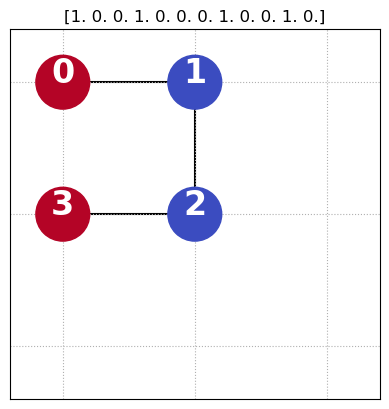

In [4]:
# Draw the protein
print('First solution in the feasible solution set: ')
x = [True if x > 0 else False for x in feasible_set[0]]
y = protein.get_bit_names()
print([b for a, b in zip(x, y) if a])

protein.viz_lattice(feasible_set[0])

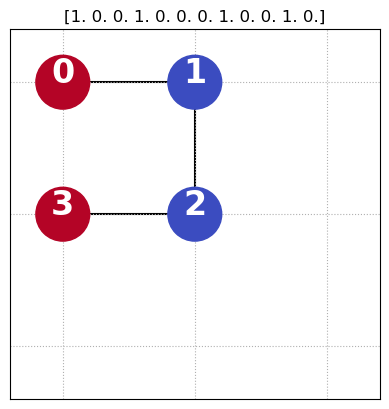

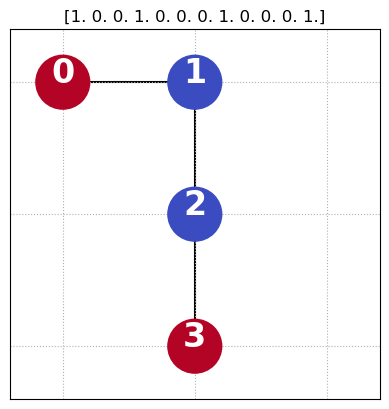

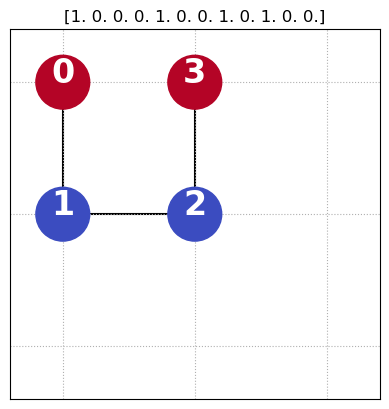

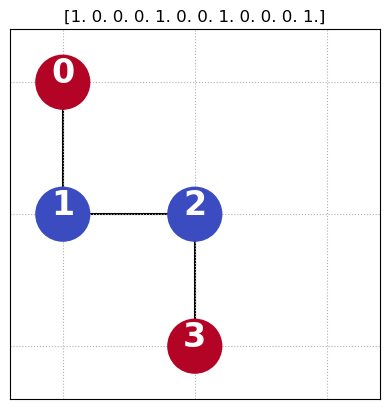

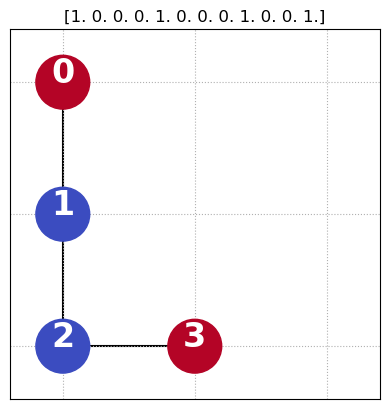

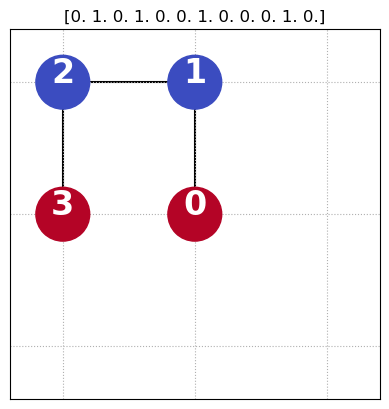

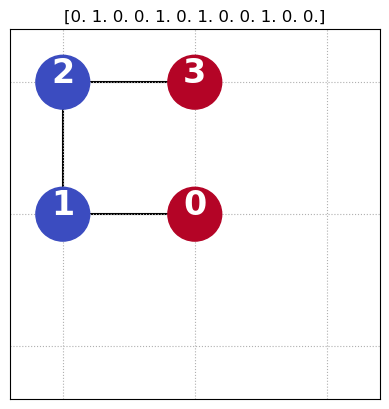

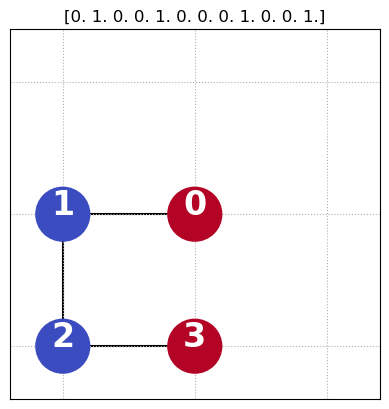

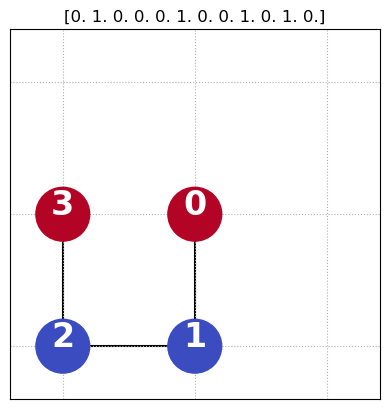

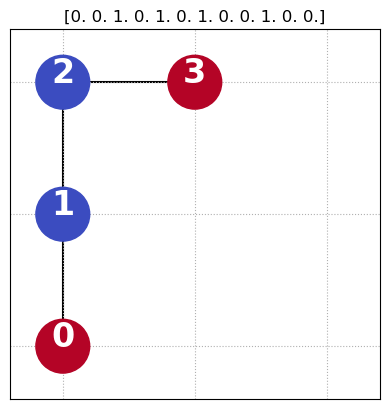

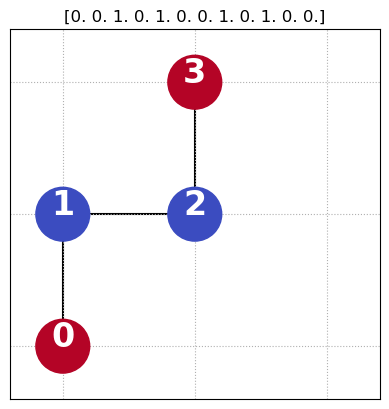

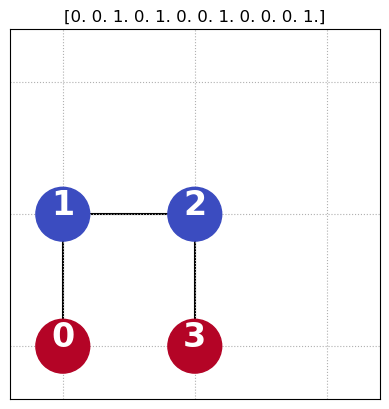

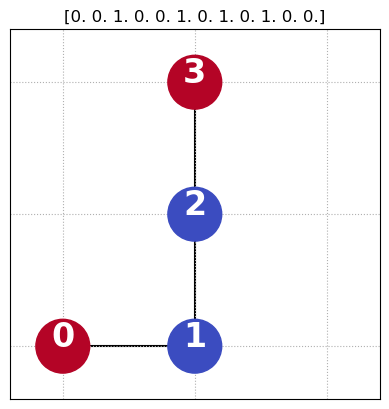

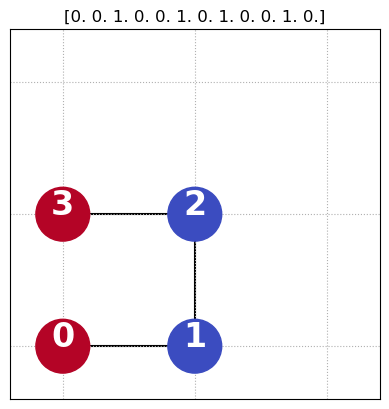

In [5]:
# Draw all proteins in feasible solution set
for j,i in enumerate(feasible_set):
    plt.figure(j)
    protein.viz_lattice(i)

## Quantum Approximate Optimization Algorithm (QAOA)
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
In QAOA, the circuit is done in a sequence of depth $p$:
\begin{equation}
    \begin{split}
        \ket{\psi_p(\gamma, \beta)} = & e^{-i\beta_p H_{mixer}} e^{-i\gamma_p H_{\text{cost}}}\\
        &... e^{-i\beta_1 H_{mixer}} e^{-i\gamma_1 H_{\text{cost}}} \ket{\psi_{\text{init.}}},
    \end{split}
\end{equation}
where $\gamma$ and $\beta$ are vectors of parameters to optimise by a classical computer so that the probability of measuring the optimal state is high.

The function to optimise is often the expectation value
\begin{equation}
    C_{\text{obj.}} = \bra{\psi_p(\gamma, \beta)}H_{cost}\ket{\psi_p(\gamma, \beta)},
\end{equation}
where $C_{\text{obj.}}$ is the energy function in our case.
If we get the lowest expectation value, we should get the answer with the lowest energy.

For details on how to run QAOA in Pennylane: https://pennylane.ai/qml/demos/tutorial_qaoa_intro

### Protein instance into cost Hamiltonian

Here, we create a cost Hamiltonian from the protein by translating the binary variables $x_i=\{0,1\}$ to spin $q_i=\{1,-1\}$ for the qubits. We end up with a problem on the form of an Ising Hamiltonian:

\begin{equation}
    H_{\text{cost}} = \sum_i h_i \sigma_i^z + \sum_{ij} J_{ij} \sigma_i^z \sigma_j^z,
\end{equation}
where $h_i$ are the field constants applied to qubit $i$ translated from the one-body energies, $J_{ij}$ are the two-body interaction constants between qubit $i$ and $j$ translated from the two-body energies and $\sigma^z$ is the Pauli operator in the $z$-direction.

In [6]:
def protein_folding_hamiltonian(ProteinInstance):
	'''
	Input: Protein instance from CoordinateBased_HPLattice or RotamerRosetta.
	Returns: The hamiltonian for the protein instance.
	'''
	num_qubits = len(ProteinInstance.O_energies)
	wires = range(ProteinInstance.num_bits)

	O_coeffs = [-x/2 for x in ProteinInstance.O_energies] 

	T_coeffs = np.copy(ProteinInstance.T_energies)

	for j in range(num_qubits):                         
		for k in range(num_qubits):
			T_coeffs[j,k] = T_coeffs[j,k]/4

	H_cost = get_cost_hamiltonian(O_coeffs, T_coeffs, wires)
	return H_cost

def get_cost_hamiltonian(O_coeffs, T_coeffs, wires):
	H_cost_O = get_O_hamiltonian(O_coeffs, wires)
	H_cost_T = get_T_hamiltonian(T_coeffs, wires)
	return H_cost_O + H_cost_T

def get_O_hamiltonian(O_coeffs, wires):
	return qml.Hamiltonian(O_coeffs, [qml.PauliZ(i) for i in wires])

def get_T_hamiltonian(T_coeffs, wires):
	obs = []
	coeffs = []
	for j in wires:
		for k in range(j+1, len(wires)):
			coeffs.append(T_coeffs[j,k]) 
			coeffs.append(-T_coeffs[j,k])
			coeffs.append(-T_coeffs[j,k])
			obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
			obs.append(qml.PauliZ(j))
			obs.append(qml.PauliZ(k))
	return qml.Hamiltonian(coeffs, obs)

In [7]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits) # naming the qubits
print('H_cost:\n' + str(H_cost))

H_cost:
1.05 * Z(0) + 1.05 * Z(1) + 1.05 * Z(2) + 1.05 * Z(3) + 1.05 * Z(4) + 1.05 * Z(5) + 1.05 * Z(6) + 1.05 * Z(7) + 1.05 * Z(8) + 1.05 * Z(9) + 1.05 * Z(10) + 1.05 * Z(11) + 1.05 * (Z(0) @ Z(1)) + -1.05 * Z(0) + -1.05 * Z(1) + 1.05 * (Z(0) @ Z(2)) + -1.05 * Z(0) + -1.05 * Z(2) + 0.0 * (Z(0) @ Z(3)) + -0.0 * Z(0) + -0.0 * Z(3) + 0.0 * (Z(0) @ Z(4)) + -0.0 * Z(0) + -0.0 * Z(4) + 0.75 * (Z(0) @ Z(5)) + -0.75 * Z(0) + -0.75 * Z(5) + 0.6 * (Z(0) @ Z(6)) + -0.6 * Z(0) + -0.6 * Z(6) + 0.0 * (Z(0) @ Z(7)) + -0.0 * Z(0) + -0.0 * Z(7) + 0.0 * (Z(0) @ Z(8)) + -0.0 * Z(0) + -0.0 * Z(8) + -0.25 * (Z(0) @ Z(9)) + 0.25 * Z(0) + 0.25 * Z(9) + -0.25 * (Z(0) @ Z(10)) + 0.25 * Z(0) + 0.25 * Z(10) + 0.0 * (Z(0) @ Z(11)) + -0.0 * Z(0) + -0.0 * Z(11) + 1.05 * (Z(1) @ Z(2)) + -1.05 * Z(1) + -1.05 * Z(2) + 0.0 * (Z(1) @ Z(3)) + -0.0 * Z(1) + -0.0 * Z(3) + 0.0 * (Z(1) @ Z(4)) + -0.0 * Z(1) + -0.0 * Z(4) + 0.0 * (Z(1) @ Z(5)) + -0.0 * Z(1) + -0.0 * Z(5) + 0.0 * (Z(1) @ Z(6)) + -0.0 * Z(1) + -0.0 * Z(6) + 0.

### Ground state of the cost Hamiltonian
The native states of the protein are the ground states of the cost Hamiltonian. We need it to benchmark our algorithm's performance.

In [8]:
ground_energy, ground_states_index = get_ground_states_i(feasible_set, H_cost) # get the ground states

# This function is cheating! It is an extensive search through all solutions to find the one with the lowest energy.
# But we use it for benchmarking our algorithm on small problem instances.
print('Ground energy: ', ground_energy)

Ground energy:  -15.75


### We also need a mixer Hamiltonian for our QAOA

Pennylane has a command to get a simple X-mixer:
\begin{equation}
    H_{\text{mixer}} = \sum_i \sigma_i^x.
\end{equation}
where $\sigma^x$ is the Pauli operator in the $x$-direction.

In [9]:
H_mixer = qaoa.x_mixer(qubits)
print('H_mixer:\n' + str(H_mixer))

H_mixer:
1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3) + 1 * X(4) + 1 * X(5) + 1 * X(6) + 1 * X(7) + 1 * X(8) + 1 * X(9) + 1 * X(10) + 1 * X(11)


### Using Pennylane to build the QAOA circuit


In [10]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params):     # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1]) # Repeats our layer p=len(params[0]) times.

# If we add a expectation value we get a cost function for average cost of the cost Hamiltonian for given parameters
@qml.qnode(dev)
def average_cost(params):
    circuit(params)
    return qml.expval(H_cost)

# Let's test it! Only one layer.
zero_parameters = np.array([[0],[0]]) # Gamma and Beta both set to 0.
half_parameters = np.array([[0.5],[0.5]])  # Gamma and Beta both set to 0.5.

#print('Average cost with gamma=0 and beta=0:\n', average_cost(zero_parameters))
print('Average cost with gamma=0.5 and beta=0.5:\n', average_cost(half_parameters))

# Draw our circuit
print()
# print(qml.draw(average_cost, expansion_strategy = 'device')(zero_parameters))

Average cost with gamma=0.5 and beta=0.5:
 1.1427348288655956



## Optimisation of the circuit parameters with a gradient descent

We walk in parameter space to find the best parameters to get a high probability for the low energy states.

In [11]:
# Define which optimiser we want to use, AdamOptimizer() is another option
optimiser = qml.GradientDescentOptimizer()

# How many steps are we taking
steps = 20 

# Naive initial parameters
initial_params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad = True)

# Number of layers in our circuit
p = 2

# Vectors for saving the information
cost_vector = np.zeros(steps)
cost_vector[0] = average_cost(initial_params)
params_vector = np.zeros((steps, 2, p))

# Loop for performing the optimisation
params = initial_params
for i in range(steps):
    params_vector[i] = params
    params, cost_ = optimiser.step_and_cost(average_cost, params)
    cost_vector[i] = cost_

# How did we do?
best_params_optimisation = params
print('Optimal parameters after gradient descent:\n', best_params_optimisation)
print('\nAverage cost for the best parameters:', average_cost(best_params_optimisation))
print('Compared to the ground energy: ', ground_energy)

Optimal parameters after gradient descent:
 [[0.58036313 0.20126803]
 [0.40120566 0.48723116]]

Average cost for the best parameters: -1.4518091105789617
Compared to the ground energy:  -15.75


Text(0.5, 1.0, 'Optimisation of $\\gamma$ and $\\beta$')

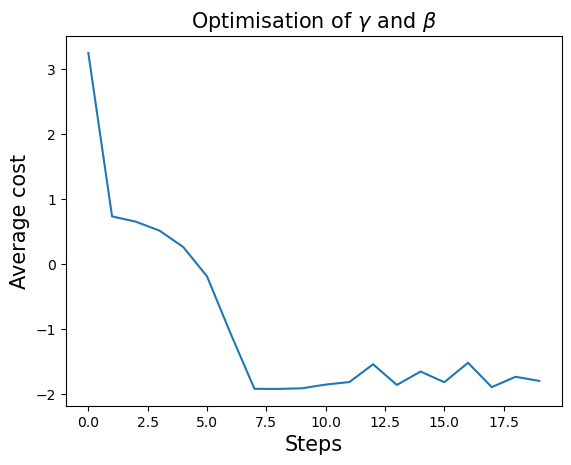

In [12]:
# Let's plot that
# plt.style.use("seaborn")
plt.plot(cost_vector)
plt.xlabel('Steps', fontsize = 15)
plt.ylabel('Average cost', fontsize = 15)
plt.title(r'Optimisation of $\gamma$ and $\beta$', fontsize = 15)

### Evaluation of optimisation of cirquit parameters

We can see that the average cost of the circuit is lower than for the initial parameters. However, what does that mean for our protein? We want to ensure the probability to find the best fold is as high as possible.

Success probability or Overlap with solution:
\begin{equation}
    SP(\gamma, \beta) = |\braket{x_{best}}{\gamma, \beta}|^2
\end{equation}
which is the probability of measuring the solution given the parameters $\gamma, \beta$.

In [13]:
# A function for obtaining the probability of measuring the different foldings
# in the end of the circuit given a set of parameters
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires = qubits)


probs = probability_circuit(best_params_optimisation)
print('Success probability: ', np.sum(probs[ground_states_index]))

Success probability:  0.0028792485528006334


<Figure size 640x480 with 0 Axes>

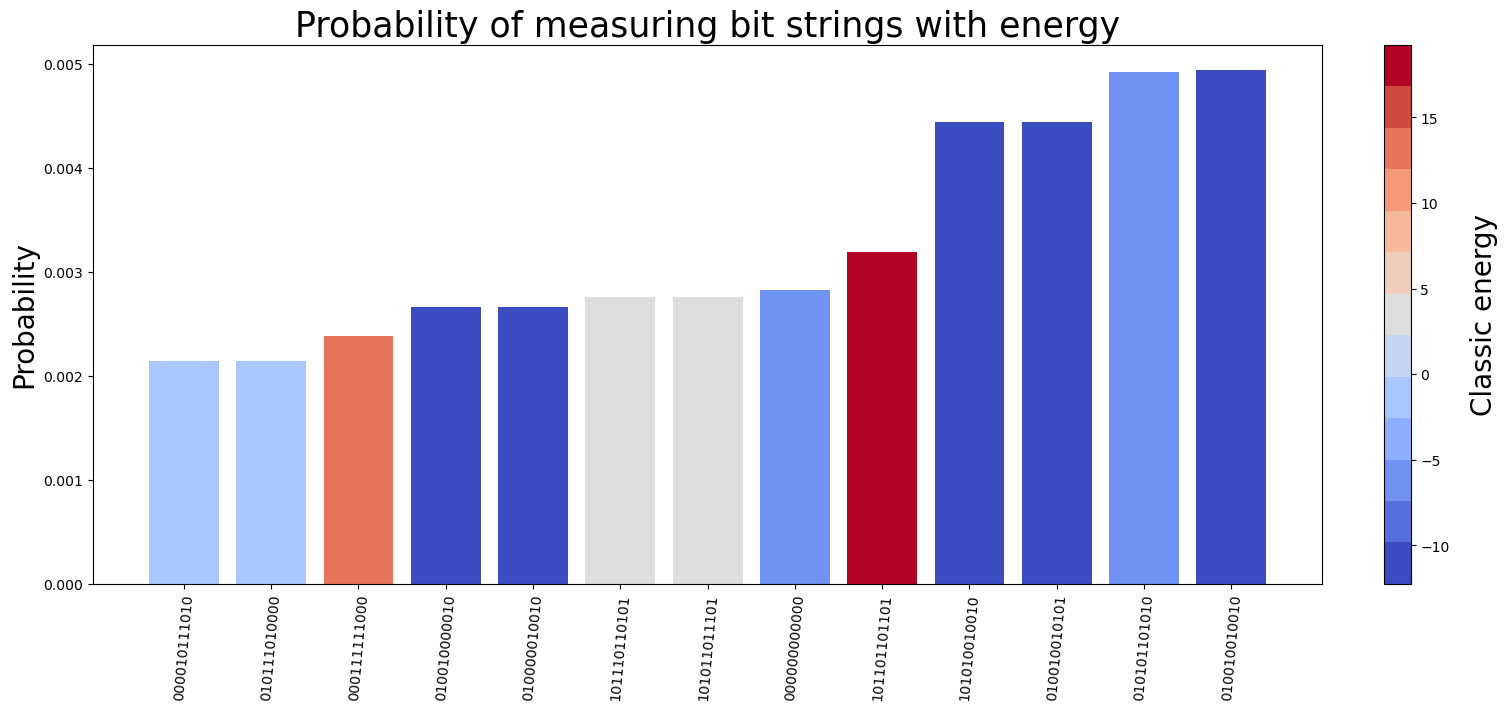

In [14]:
# Plot all solutions with a probability over a threshhold (to not over crowd the graph)
# The color of the graph is the classical energy of the solution/fold.
# A ground state will have a green label.

# If the there are no solutions with a probability over the threshhold we don't get a graph.
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_index, threshhold = 0.002) # plot probability over bitstrings

Only one or two layers of the circuit will not perform very good.

## Here follows a different ways to get a better success probability

You can choose to continue tweeking above code to give better answers or to explore other suggestions for optimisation.

## Changing to a smarter mixer Hamiltonian

We can put one constraint in the mixer part of the QAOA algorithm.
See Hadfield et al. 2019: https://www.mdpi.com/1999-4893/12/2/34


The XY-mixer smarter mixer that uses the clusters of the positions on the grids deleting one constraint, by keeping the Hamming distance of the clusters.

\begin{equation}
    H_{XY-mixer} = \frac{1}{2} \sum_{i,j \in E(G)} (\sigma^x_i \sigma^x_j + \sigma^y_i \sigma^y_j),
\end{equation}

where the sum is over the edges in the graph $G$.

In [15]:
# Here is documentation https://docs.pennylane.ai/en/stable/code/api/pennylane.qaoa.mixers.xy_mixer.html
# protein.Dn is the graph you need

## Optimisation of the circuit parameters with grid search
 
Try all the parameters and save the best one. Not a great way to find the best parameters, but if we get them for p=1, then we may interpolate to a good initial guess for higher p.


/opt/miniconda3/envs/UA_FarmaIAQC_2025/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)


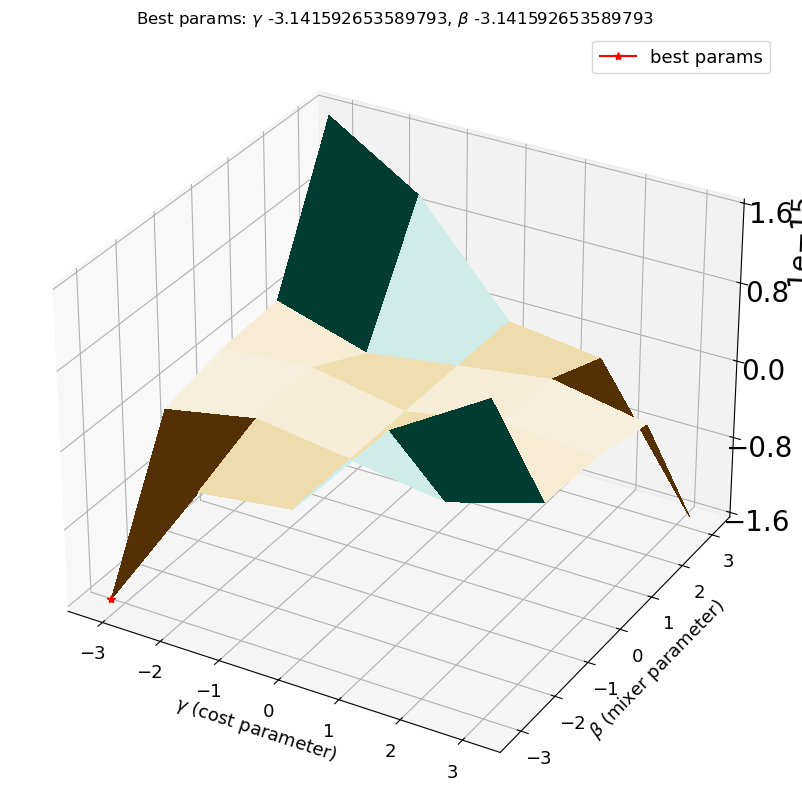

In [16]:
# Grid search
p = 1

start_gamma = -np.pi
stop_gamma = np.pi
num_points_gamma = 5 # the more points the better answer, but the longer the wait

start_beta = -np.pi
stop_beta = np.pi
num_points_beta = 5 # the more points the better answer, but the longer the wait

# Gamma
X = np.linspace(start_gamma, stop_gamma, num_points_gamma)
# Beta
Y = np.linspace(start_beta, stop_beta, num_points_beta)

grid_search_params, Z, i = grid_search(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta,
					average_cost,
					above = False,
					save = False)

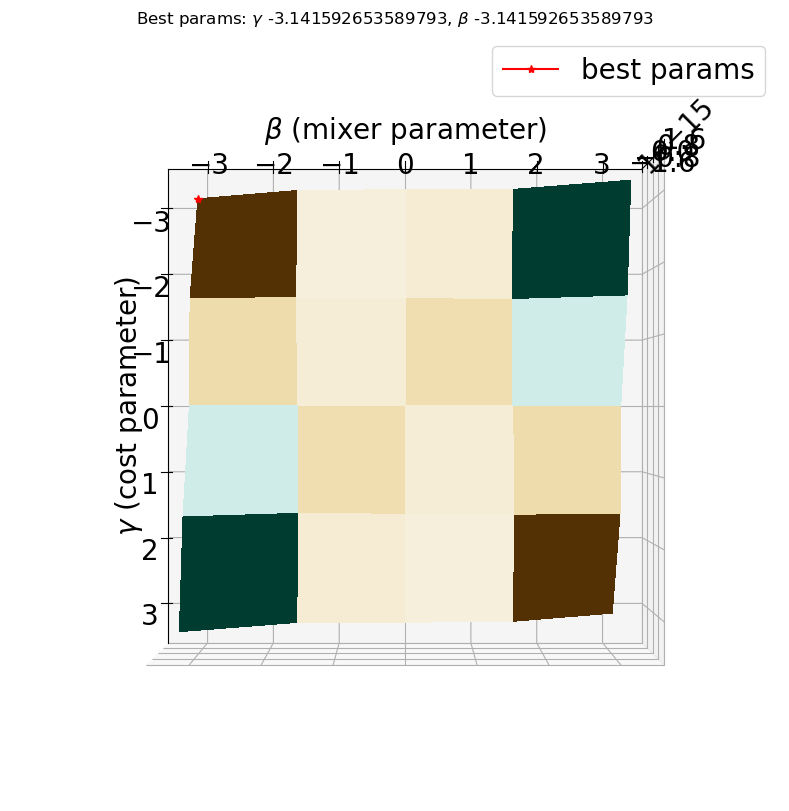

In [17]:
# More plotting, from above

X, Y, _= get_batch_array(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta)
                
plot_grid_search(X,
					Y,
					Z,
					i,
					above = True,
					name = '',
					save = False,
                fontsize = 20)

In [18]:
# Is the grid search better?
probs = probability_circuit(grid_search_params)

plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_index)

print('Success probability of grid search: ', np.sum(probs[ground_states_index]))

No solutions with a probability over the given threshhold:  0.001
Success probability of grid search:  0.0019531249999999911


### Interpolate parameters

For more details see Appendix B part 1. "Interpolation-based strategy" Lukin et al. 2020: https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.021067

In [19]:
# Interpolate parameters to get next parameters to optimise over

interpolated_params = interpolate_params(grid_search_params, save = False, plot = False, only_last=False)

probs = probability_circuit(interpolated_params)
print('Success probability of interpolated annealing parameters: ', np.sum(probs[ground_states_index]))

# You can also interpolate from an optimisation run.

Success probability of interpolated annealing parameters:  0.0019531249999999857


In [20]:
# Grid search for p=2.
# Takes a long time so this cell may be skipped.

# Will build a 4-dimensional vector and go though all values getting the heurustic functions result.
# Then return the best parameters [0], and the tensor with the values [1].
params_p2 = vec_grid_search_p2(start_gamma = -np.pi,
						stop_gamma = np.pi,
						num_points_gamma = 5, # keep in mind that a value over 10 will take forever
						start_beta = -np.pi,
						stop_beta = np.pi,
						num_points_beta = 5, # keep in mind that a value over 10 will take forever
						heuristic = average_cost,
						vmap = False)[0]

probs = probability_circuit(params_p2)
print('Success probability of grid search p=2: ', np.sum(probs[ground_states_index]))


Success probability of grid search p=2:  0.0019531249999999733


In [21]:
# Interpolate from best parameters for p=2 to p=3.

params_p3 = interpolate_params(params_p2, save = False, plot = False, only_last=False)

probs = probability_circuit(params_p3)
print('Success probability of grid search p=3: ', np.sum(probs[ground_states_index]))



Success probability of grid search p=3:  0.0015532100101124965


## Optimisation of the circuit parameters with quantum annealing initialisation

We can warm start the search for the best parameters by taking inspiration from quantum annealing.
Read more here: https://quantum-journal.org/papers/q-2021-07-01-491/

In [22]:
annealing_params = get_annealing_params(annealing_time=2, 
                                        p=10, 
                                        linear = True, 
                                        cosine = False,
                                        sine = False,
                                        save = False,
                                        plot = False)
plt.figure(10)

probs = probability_circuit(annealing_params)

print('Success probability of annealing parameters: ', np.sum(probs[ground_states_index]))

Success probability of annealing parameters:  0.10252902909875927


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

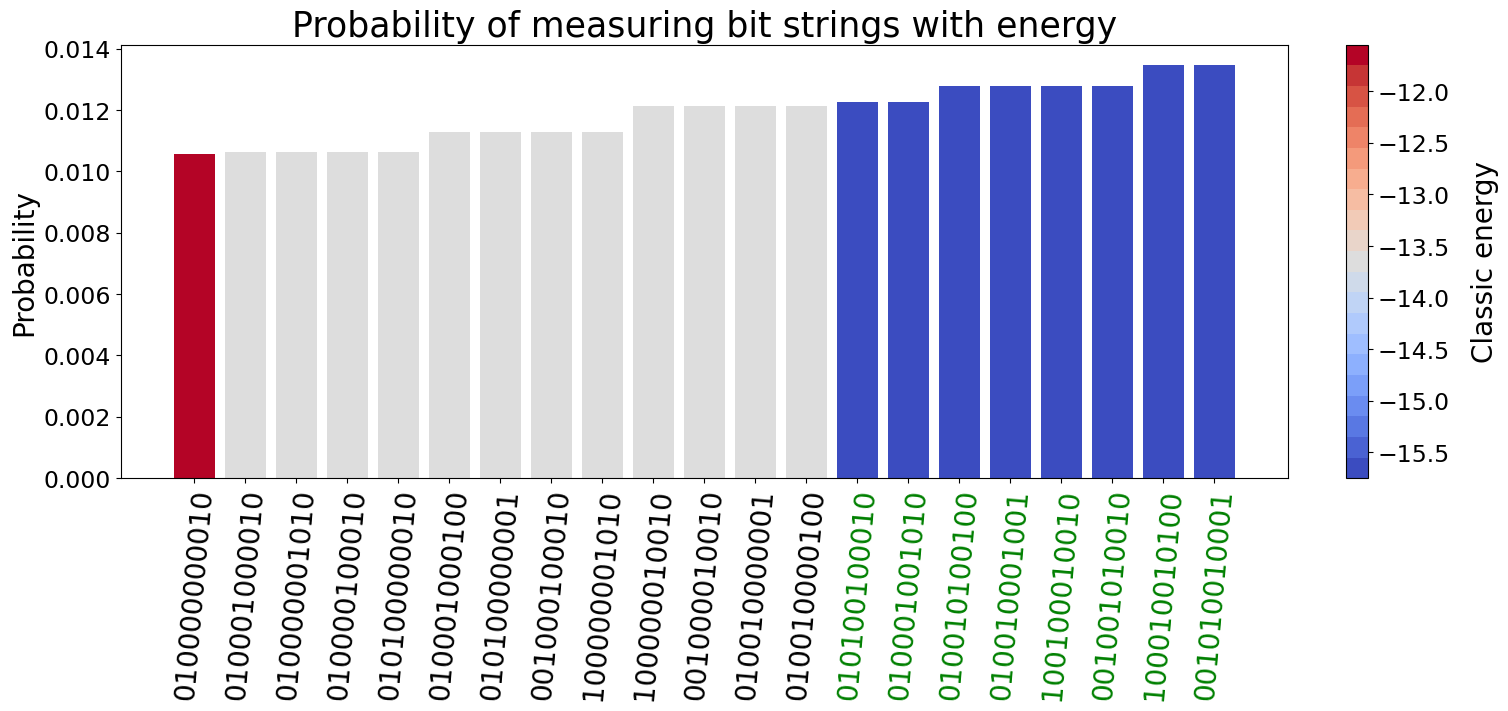

In [23]:
# Is the annealing parameters better better?
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_index, threshhold = 0.01)


## JAX and JIT
Read more here: https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html

In [24]:
# Use JAX and JIT packages to speed up the process. Calls for extensive installations.
# JIT is just-in-time compilation and will only work with small instances. If the number of qubits is 18 or more then the allocation of memory will complain.
# JAX work the fastest on a GPU, but still faster using vmap on the CPU.

# In order to run the just in time compilation and JAX, we need another qnode device.
# This wrapper function will do the job.
def jax_average_cost(params):
    '''
    Cost function with average cost of the state as metric.
    Jax version to be used with batches.
    '''
    #@jit
    @qml.qnode(dev, interface = 'jax')
    def _average_cost(params):
        circuit(params)
        return qml.expval(H_cost)
    return _average_cost(params)


params_p2 = vec_grid_search_p2(start_gamma = -np.pi,
						stop_gamma = np.pi,
						num_points_gamma = 10, # keep in mind that a value over 10 will take forever
						start_beta = -np.pi,
						stop_beta = np.pi,
						num_points_beta = 10,
						heuristic= jax_average_cost,
						vmap = True)[0]

probs = probability_circuit(params_p2)
print('Success probability of grid search p=2: ', np.sum(probs[ground_states_index]))

Batch list done!
Success probability of grid search p=2:  0.011747799311555944
Success probability of grid search p=2:  0.011747799311555944


/var/folders/_k/zc3gtmkn2f39sfwhbsx6yndc0000gs/T/ipykernel_72513/2452456568.py:740: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(name + '_num_gamma' + str(num_points_gamma) + '.pdf')


[[-0.19234241]
 [ 0.44879895]]


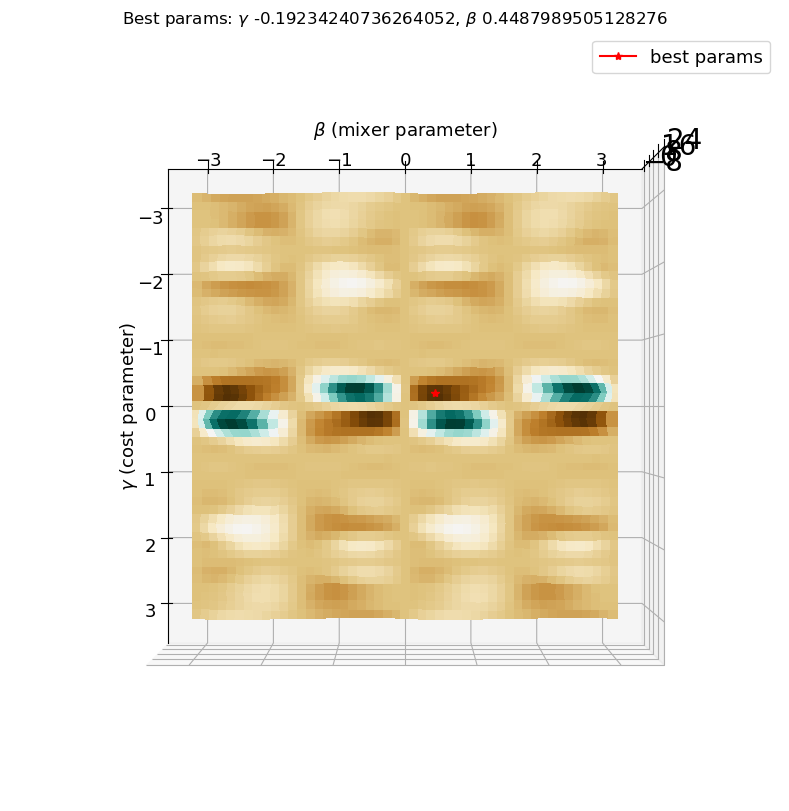

In [25]:
# JAX for p=1.

grid_search_params, Z, i = grid_search(start_gamma = -np.pi,
						stop_gamma = np.pi,
						num_points_gamma = 50, # keep in mind that a value over 10 will take forever
						start_beta = -np.pi,
						stop_beta = np.pi,
						num_points_beta = 50,
						heuristic= jax_average_cost,
						vmap = True,
                        above = True,
                        save = True)
print(grid_search_params)
